## CS444-Whale and Dolphin Identification

In [16]:
!pip install -q bbox-utility 

# Import Libraries

In [17]:
import numpy as np
import pandas as pd
import os
import glob
import shutil
from tqdm.notebook import tqdm
from joblib import Parallel, delayed

from bbox.utils import yolo2voc, draw_bboxes

import cv2
import matplotlib.pyplot as plt

# Config

In [18]:
BASE_PATH = '../input/happywhale-boundingbox-yolov5-dataset'
IMG_SIZE = (768, 768) # new image resolution
CONF = 0.6 # confidence threshold for bbox

# Meta Data

In [19]:
df = pd.read_csv(BASE_PATH+'/train.csv')
df['label_path'] = df['label_path'].map(lambda x: x.replace('/kaggle/working',BASE_PATH))

test_df = pd.read_csv(BASE_PATH+'/test.csv')
test_df['label_path'] = test_df['label_path'].map(lambda x: x.replace('/kaggle/working',BASE_PATH))

# Pseudo Labelling

In [20]:
df = df.fillna('[]')
test_df = test_df.fillna('[]')

In [21]:
df['bbox'] = df['bbox'].map(eval)
test_df['bbox'] = test_df['bbox'].map(eval)

df['conf'] = df['conf'].map(eval)
test_df['conf'] = test_df['conf'].map(eval)

# Crop Function

In [22]:
def load_image(path):
    return cv2.imread(path)[...,::-1]

np.random.seed(32)
colors = [(np.random.randint(255), np.random.randint(255), np.random.randint(255))\
          for idx in range(1)]

def crop_image(row):
    image_path = row['image_path']
    if 'train' in image_path:
        save_dir = '/tmp/train_images'
    else:
        save_dir = '/tmp/test_images'
    img = load_image(image_path)
    if len(row['bbox']): # if there is no bbox
        bbox = row['bbox'][0]
        conf = row['conf'][0]
        if conf>=CONF: # don't crop for poor confident bboxes
            xmin, ymin, xmax, ymax = bbox
            img = img[ymin:ymax, xmin:xmax] # crop image
    img = cv2.resize(img[...,::-1], dsize=IMG_SIZE, interpolation=cv2.INTER_AREA)
    cv2.imwrite(f'{save_dir}/{row.image_id}', img) # save image in the new directory
    return

# Visualization

## Train Images

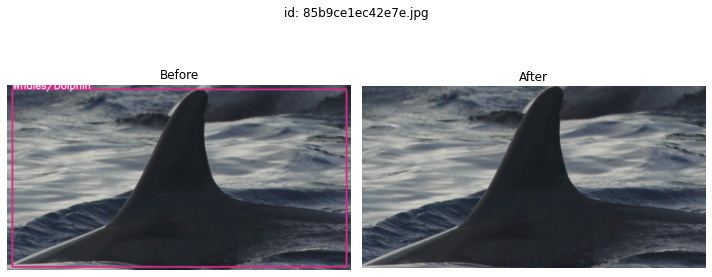

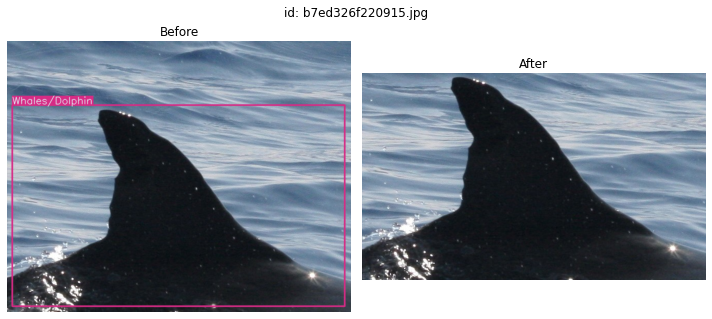

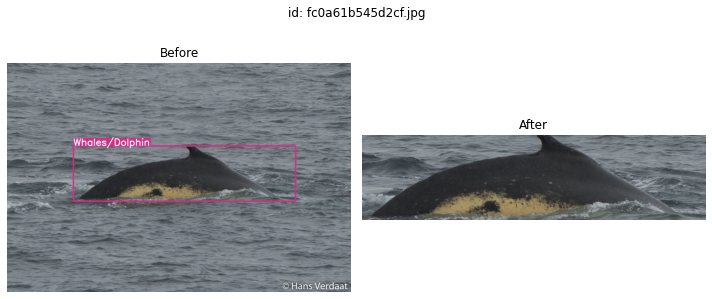

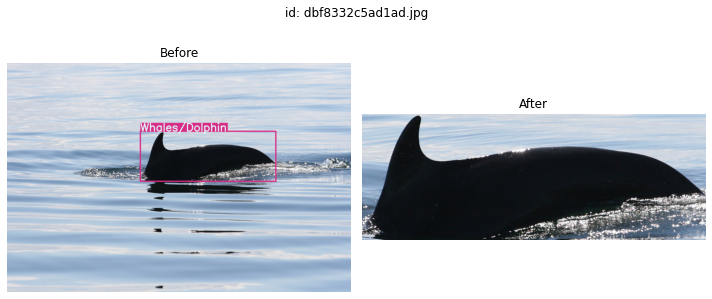

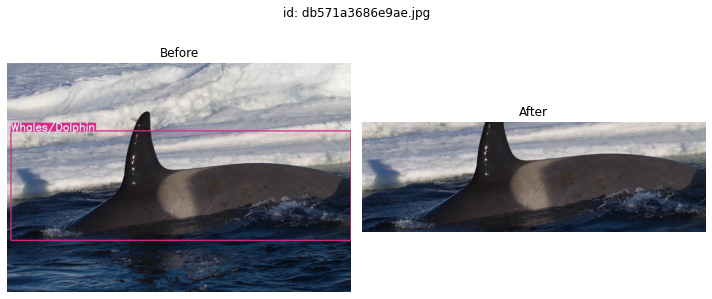

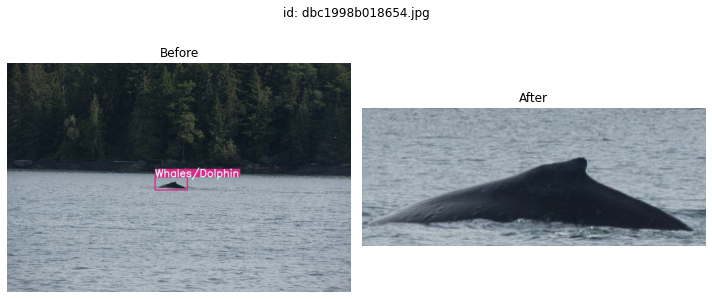

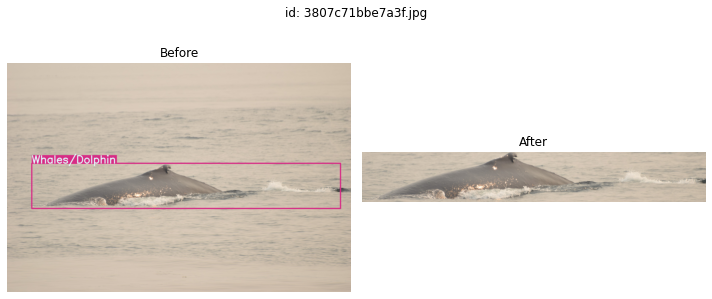

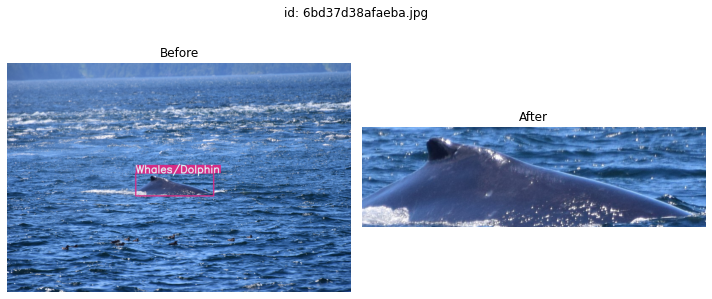

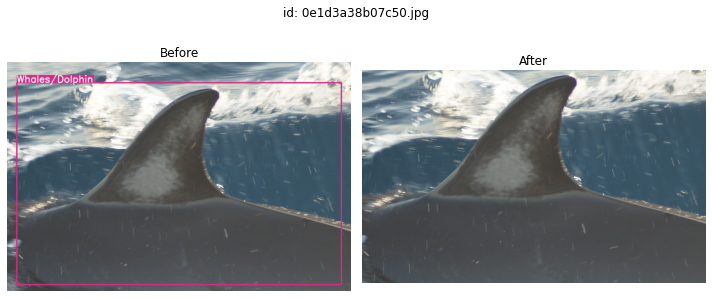

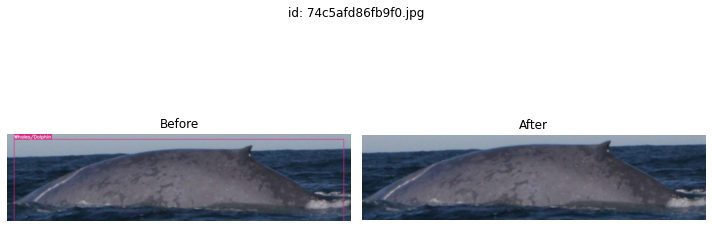

In [23]:
for i in range(10):
    row = df.sample(frac=1.0).iloc[i]
    img = load_image(row.image_path)
    bbox = row['bbox'][0]
    xmin, ymin, xmax, ymax = bbox

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
#     plt.imshow(img)
    dim = np.sqrt(np.prod(img.shape[:2]))
    line_thickness = int(2/512*dim)
    plt.imshow(
            draw_bboxes(
                img=img,
                bboxes=np.array(row['bbox']),
                classes=['Whales/Dolphin'],
                class_ids=[0],
                class_name=True,
                colors=colors,
                bbox_format="voc",
                line_thickness=line_thickness,
            ))
    plt.title('Before')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(img[ymin:ymax, xmin:xmax])
    plt.title('After')
    plt.axis('off')
    
    plt.suptitle(f'id: {row.image_id}', y=0.94)
    plt.tight_layout()
    plt.show()

## Test

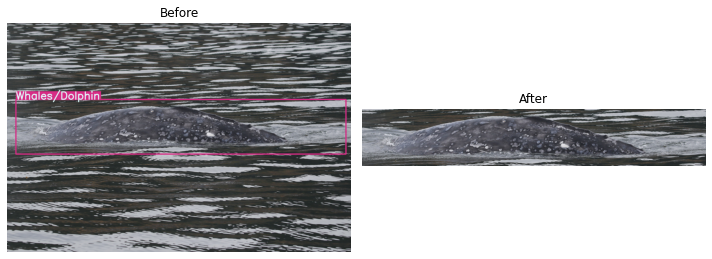

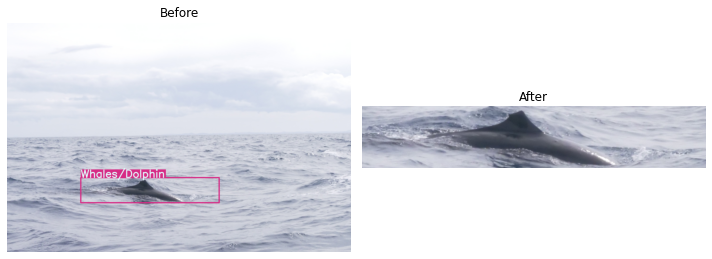

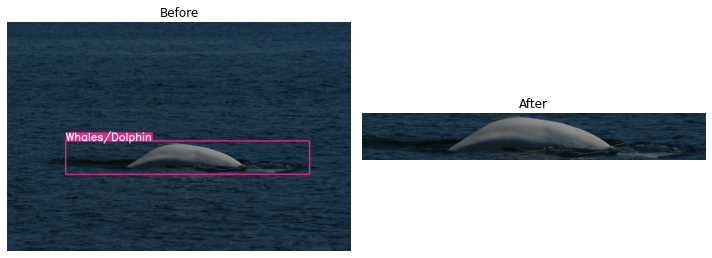

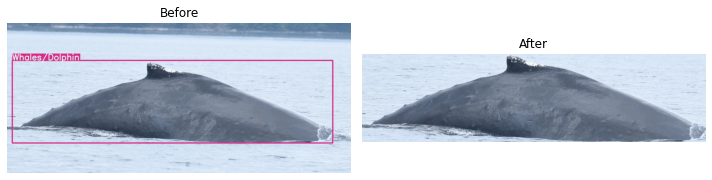

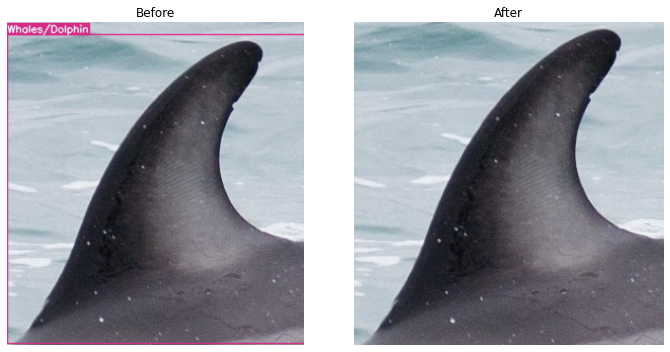

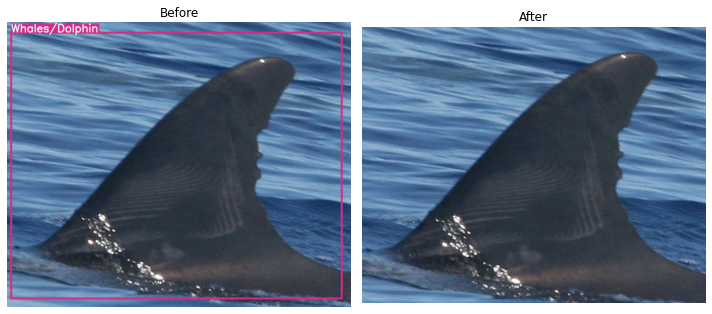

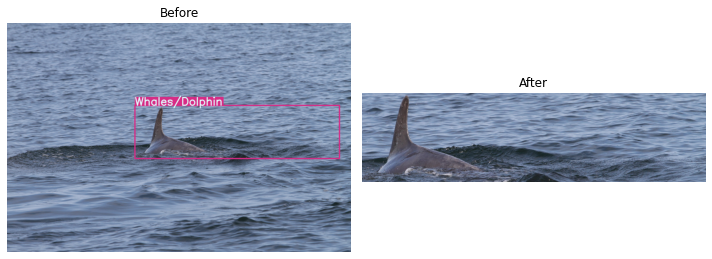

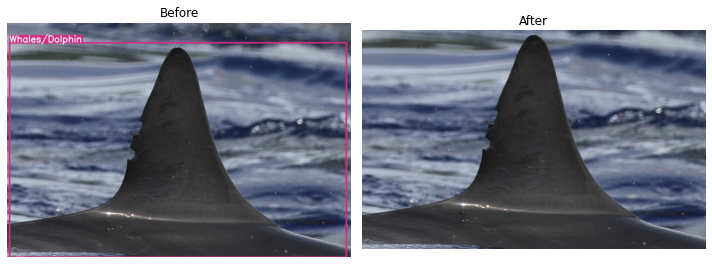

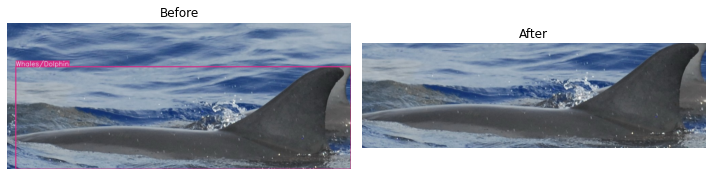

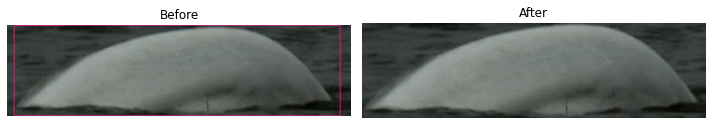

In [24]:
for i in range(10):
    row = test_df.iloc[i]
    img = load_image(row.image_path)
    bbox = row['bbox'][0]
    xmin, ymin, xmax, ymax = bbox

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
#     plt.imshow(img)
    dim = np.sqrt(np.prod(img.shape[:2]))
    line_thickness = int(2/512*dim)
    plt.imshow(
            draw_bboxes(
                img=img,
                bboxes=np.array(row['bbox']),
                classes=['Whales/Dolphin'],
                class_ids=[0],
                class_name=True,
                colors=colors,
                bbox_format="voc",
                line_thickness=line_thickness,
            ))
    plt.title('Before')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(img[ymin:ymax, xmin:xmax])
    plt.title('After')
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()

# Create Save Directory

In [25]:
!mkdir -p /tmp/train_images && mkdir -p /tmp/test_images

# Crop

In [26]:
# Train
_ = Parallel(n_jobs=-1, backend='threading')(delayed(crop_image)(row)\
                                         for _, row in tqdm(df.iterrows(), total=len(df), desc='train '))

# Test
_ = Parallel(n_jobs=-1, backend='threading')(delayed(crop_image)(row)\
                                         for _, row in tqdm(test_df.iterrows(), total=len(test_df), desc='test '))

train :   0%|          | 0/51033 [00:00<?, ?it/s]

# Save Meta Data

In [27]:
df.to_csv('train.csv',index=False)
test_df.to_csv('test.csv',index=False)

# Archive Files

In [ ]:
# Train
shutil.make_archive(base_name='/kaggle/working/train_images',
                    format='zip',
                    root_dir='/tmp/',
                    base_dir='train_images')
# Test
shutil.make_archive(base_name='/kaggle/working/test_images',
                    format='zip',
                    root_dir='/tmp/',
                    base_dir='test_images')